In [265]:
import os, sys, logging
import numpy as np

import matplotlib.pyplot as plt

from obspy.signal.filter import bandpass
from noisepy.monitoring.attenuation_utils import *
from noisepy.monitoring.monitoring_utils import *
from datetime import datetime

import pyasdf
logger = logging.getLogger(__name__)


In [266]:
# ## -----
def read_pyasdf(sfile: str, ccomp: str) -> Tuple[float, float, np.ndarray, np.ndarray]:
    # useful parameters from each asdf file
    with pyasdf.ASDFDataSet(sfile, mode="r") as ds:
        alist = ds.auxiliary_data.list()
        try:
            dt = ds.auxiliary_data[alist[0]][ccomp].parameters["dt"]
            dist = ds.auxiliary_data[alist[0]][ccomp].parameters["dist"]
            #logger.info(f"working on {sfile} (comp: {ccomp}) that is {dist} km apart. dt: {dt}")
            # read stacked data
            sdata = ds.auxiliary_data[alist[0]][ccomp].data[:]

            # time domain variables
            npts = sdata.size
            tvec = np.arange(-npts // 2 + 1, npts // 2 + 1) * dt
            return dist, dt, tvec, sdata

        except Exception:
            #logger.warning(f"continue! no {ccomp} component exist")
            return None



In [267]:
evf='evtlst'
tempev=[]
tempevnum=0
for k in open(evf):
    tempev.append(k.split()[0])
    tempevnum=tempevnum+1
print(tempev)
print(tempevnum)


['20060115', '20060215', '20060315', '20060415', '20060515', '20060615', '20060715', '20060815', '20060915', '20061015', '20061115', '20061215', '20070115', '20070215', '20070315', '20070415', '20070515', '20070615', '20070715', '20070815', '20070915', '20071015', '20071115', '20071215', '20080115', '20080215', '20080315', '20080415', '20080515', '20080615', '20080715', '20080815', '20080915', '20081015', '20081115', '20081215', '20090115', '20090215', '20090315', '20090415', '20090515', '20090615', '20090715', '20090815', '20090915', '20091015', '20091115', '20091215', '20100115', '20100215', '20100315', '20100415', '20100515', '20100615', '20100715', '20100815', '20100915', '20101015', '20101115', '20101215', '20110115', '20110215', '20110315', '20110415', '20110515', '20110615', '20110715', '20110815', '20110915', '20111015', '20111115', '20111215', '20120115', '20120215', '20120315', '20120415', '20120515', '20120615', '20120715', '20120815', '20120915', '20121015', '20121115', '20

In [268]:
path='STACKs_sac2asdf/'

pairs=[]
npairs=0
for fd in os.listdir(path):
    if fd=='DATA4cascadia':
        continue
    pairs.append(fd)
    npairs=npairs+1
print(f"Found {len(pairs)} station pairs")
print('pairs: ',pairs)


Found 29 station pairs
pairs:  ['BGU-BGU', 'BRPU-BRPU', 'BSUT-BSUT', 'CTU-CTU', 'CVRU-CVRU', 'DUG-DUG', 'FOR1-FOR1', 'FORU-FORU', 'HMU-HMU', 'HVU-HVU', 'HWUT-HWUT', 'JLU-JLU', 'LCMT-LCMT', 'LIUT-LIUT', 'MPU-MPU', 'MTPU-MTPU', 'NLU-NLU', 'NOQ-NOQ', 'PNSU-PNSU', 'PSUT-PSUT', 'RCF', 'RDMU-RDMU', 'SPU-SPU', 'SRU-SRU', 'SWUT-SWUT', 'SZCU-SZCU', 'TCRU-TCRU', 'TCU-TCU', 'VRUT-VRUT']


In [310]:
nosta=2

stations = sorted(list(set(pair.split('-')[0] for pair in pairs)))
print('Stations: ', stations)
print(f"Found {len(stations)} stations")

src = stations[nosta]
rec = src

print('src: ', src) 
print('rec: ', rec)

Stations:  ['BGU', 'BRPU', 'BSUT', 'CTU', 'CVRU', 'DUG', 'FOR1', 'FORU', 'HMU', 'HVU', 'HWUT', 'JLU', 'LCMT', 'LIUT', 'MPU', 'MTPU', 'NLU', 'NOQ', 'PNSU', 'PSUT', 'RCF', 'RDMU', 'SPU', 'SRU', 'SWUT', 'SZCU', 'TCRU', 'TCU', 'VRUT']
Found 29 stations
src:  BSUT
rec:  BSUT


In [311]:
ref_span = datetime.strptime(tempev[0], '%Y%m%d').strftime('%Y-%m-%dT') + '-' + datetime.strptime(tempev[-1], '%Y%m%d').strftime('%Y-%m-%dT')
print('data period: ', ref_span)


data period:  2006-01-15T-2022-12-15T


In [ ]:
npts=2401
actual_ev = []

enz_system = ["EN_ave30-30","EZ_ave30-30","NZ_ave30-30"]
num_cmp=len(enz_system)

scf_temp=np.zeros((tempevnum, num_cmp, npts))
for tn, evname in enumerate(tempev):
    file = f'{src}-{rec}/{src}_{rec}_{evname}_ave30-30.h5'
    pyfile = os.path.join(path, file)
    #print('File:',pyfile)
    if not os.path.exists(pyfile):
        print(f"{pyfile} does not exist")
        continue
    for ncmp, ccomp in enumerate(enz_system):
        if ( read_pyasdf(pyfile,ccomp) == None):
            continue
        dist, dt, tvec, sdata = read_pyasdf(pyfile,ccomp) # read waveform from pyasdf 
        scf_temp[tn, ncmp]=sdata
        scf_tvec = tvec
        dist=0
    actual_ev.append(evname)

    # plt.figure(figsize=(8,2))
    # plt.plot(scf_tvec,scf_wave[tn, 0],label='EN')
    # plt.plot(scf_tvec,scf_wave[tn, 1],label='EZ')
    # plt.plot(scf_tvec,scf_wave[tn, 2],label='NZ')
    # plt.legend(loc='upper right')
print(tempev)
print(actual_ev)

nev=len(actual_ev)
scf_wave=np.zeros((nev, num_cmp, npts))

idx=np.where(np.isin( tempev, actual_ev))[0]
scf_wave[:]=scf_temp[idx]


delta = 0.05
maxlag = ((npts-1)//2)*delta
samp_freq=1/delta
ncmp=num_cmp
print(f'maxlag: {maxlag} ; delta: {delta} ; npts: {npts} ; ncmp: {ncmp}')
print(f'Actual events: {nev} over {tempevnum} ')


    

File: STACKs_sac2asdf/BSUT-BSUT/BSUT_BSUT_stack.h5
ref_wave:  [[-4.22155522e-02 -3.12525958e-06  3.69859636e-02 ... -2.43334640e-02
   2.63698120e-03  2.25202255e-02]
 [ 4.38476447e-03 -2.20260154e-02 -4.54022409e-03 ...  4.01241658e-03
  -1.52347637e-02  4.12694830e-03]
 [ 2.49599433e-03 -1.07199205e-02  5.21124899e-03 ... -2.33639986e-03
  -1.40341595e-02  8.85090698e-03]]
ref_tvec:  [-60.   -59.95 -59.9  ...  59.9   59.95  60.  ]


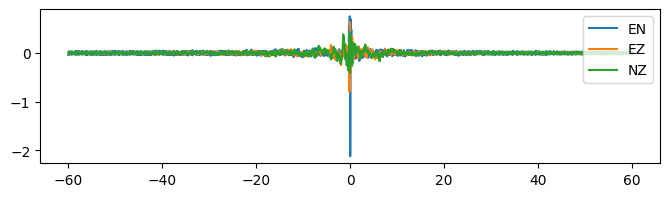

In [313]:
enz_system = ["EN","EZ","NZ"]
ref_wave=np.zeros((num_cmp, npts))

ref_file=f'{src}-{rec}/{src}_{rec}_stack.h5'
pyfile = os.path.join(path, ref_file)
print('File:',pyfile)

try: 
    for ncmp, ccomp in enumerate(enz_system):
        if ( read_pyasdf(pyfile,ccomp) == None):
            continue
        dist, dt, tvec, sdata = read_pyasdf(pyfile,ccomp) # read waveform from pyasdf 
        ref_wave[ncmp]=sdata
        dist=0
    
except Exception:
    print(f"{pyfile} does not exist")


ref_tvec = np.arange(npts)*delta - maxlag

print('ref_wave: ', ref_wave)
print('ref_tvec: ', ref_tvec)

plt.figure(figsize=(8,2))
plt.plot(ref_tvec,ref_wave[0],label='EN')
plt.plot(ref_tvec,ref_wave[1],label='EZ')
plt.plot(ref_tvec,ref_wave[2],label='NZ')
plt.legend(loc='upper right')
plt.show()

In [314]:
lag=maxlag
print(f"Lag-time: {lag}, total data length in points: {npts}")

fmin, fmax = 2,4
freq=[fmin,fmax]


Lag-time: 60.0, total data length in points: 2401


In [315]:
# %%
vdist=np.zeros((2,1))  # S-R distance array
bpuu=np.zeros((nev, num_cmp, npts))
bpref=np.zeros((num_cmp, npts))


In [ ]:
# filter data
for nfile in range(nev):
    for ncmp, ccomp in enumerate(enz_system):
        sdata=scf_wave[nfile, ncmp]
        print(f'Filtering {ccomp} component of event {nfile}')
        bpuu[nfile, ncmp] = bandpass(sdata, fmin, fmax, int(1 / delta), corners=4, zerophase=True)
        bpuu[nfile, ncmp] = bpuu[nfile, ncmp]/np.max(np.abs(bpuu[nfile, ncmp]))

# filter reference data
for ncmp, ccomp in enumerate(enz_system):
    sdata=ref_wave[ncmp]
    bpref[ncmp] = bandpass(sdata, fmin, fmax, int(1 / delta), corners=4, zerophase=True)
    bpref[ncmp] = bpref[ncmp]/np.max(np.abs(bpref[ncmp]))  
print('Filtering done')
print()

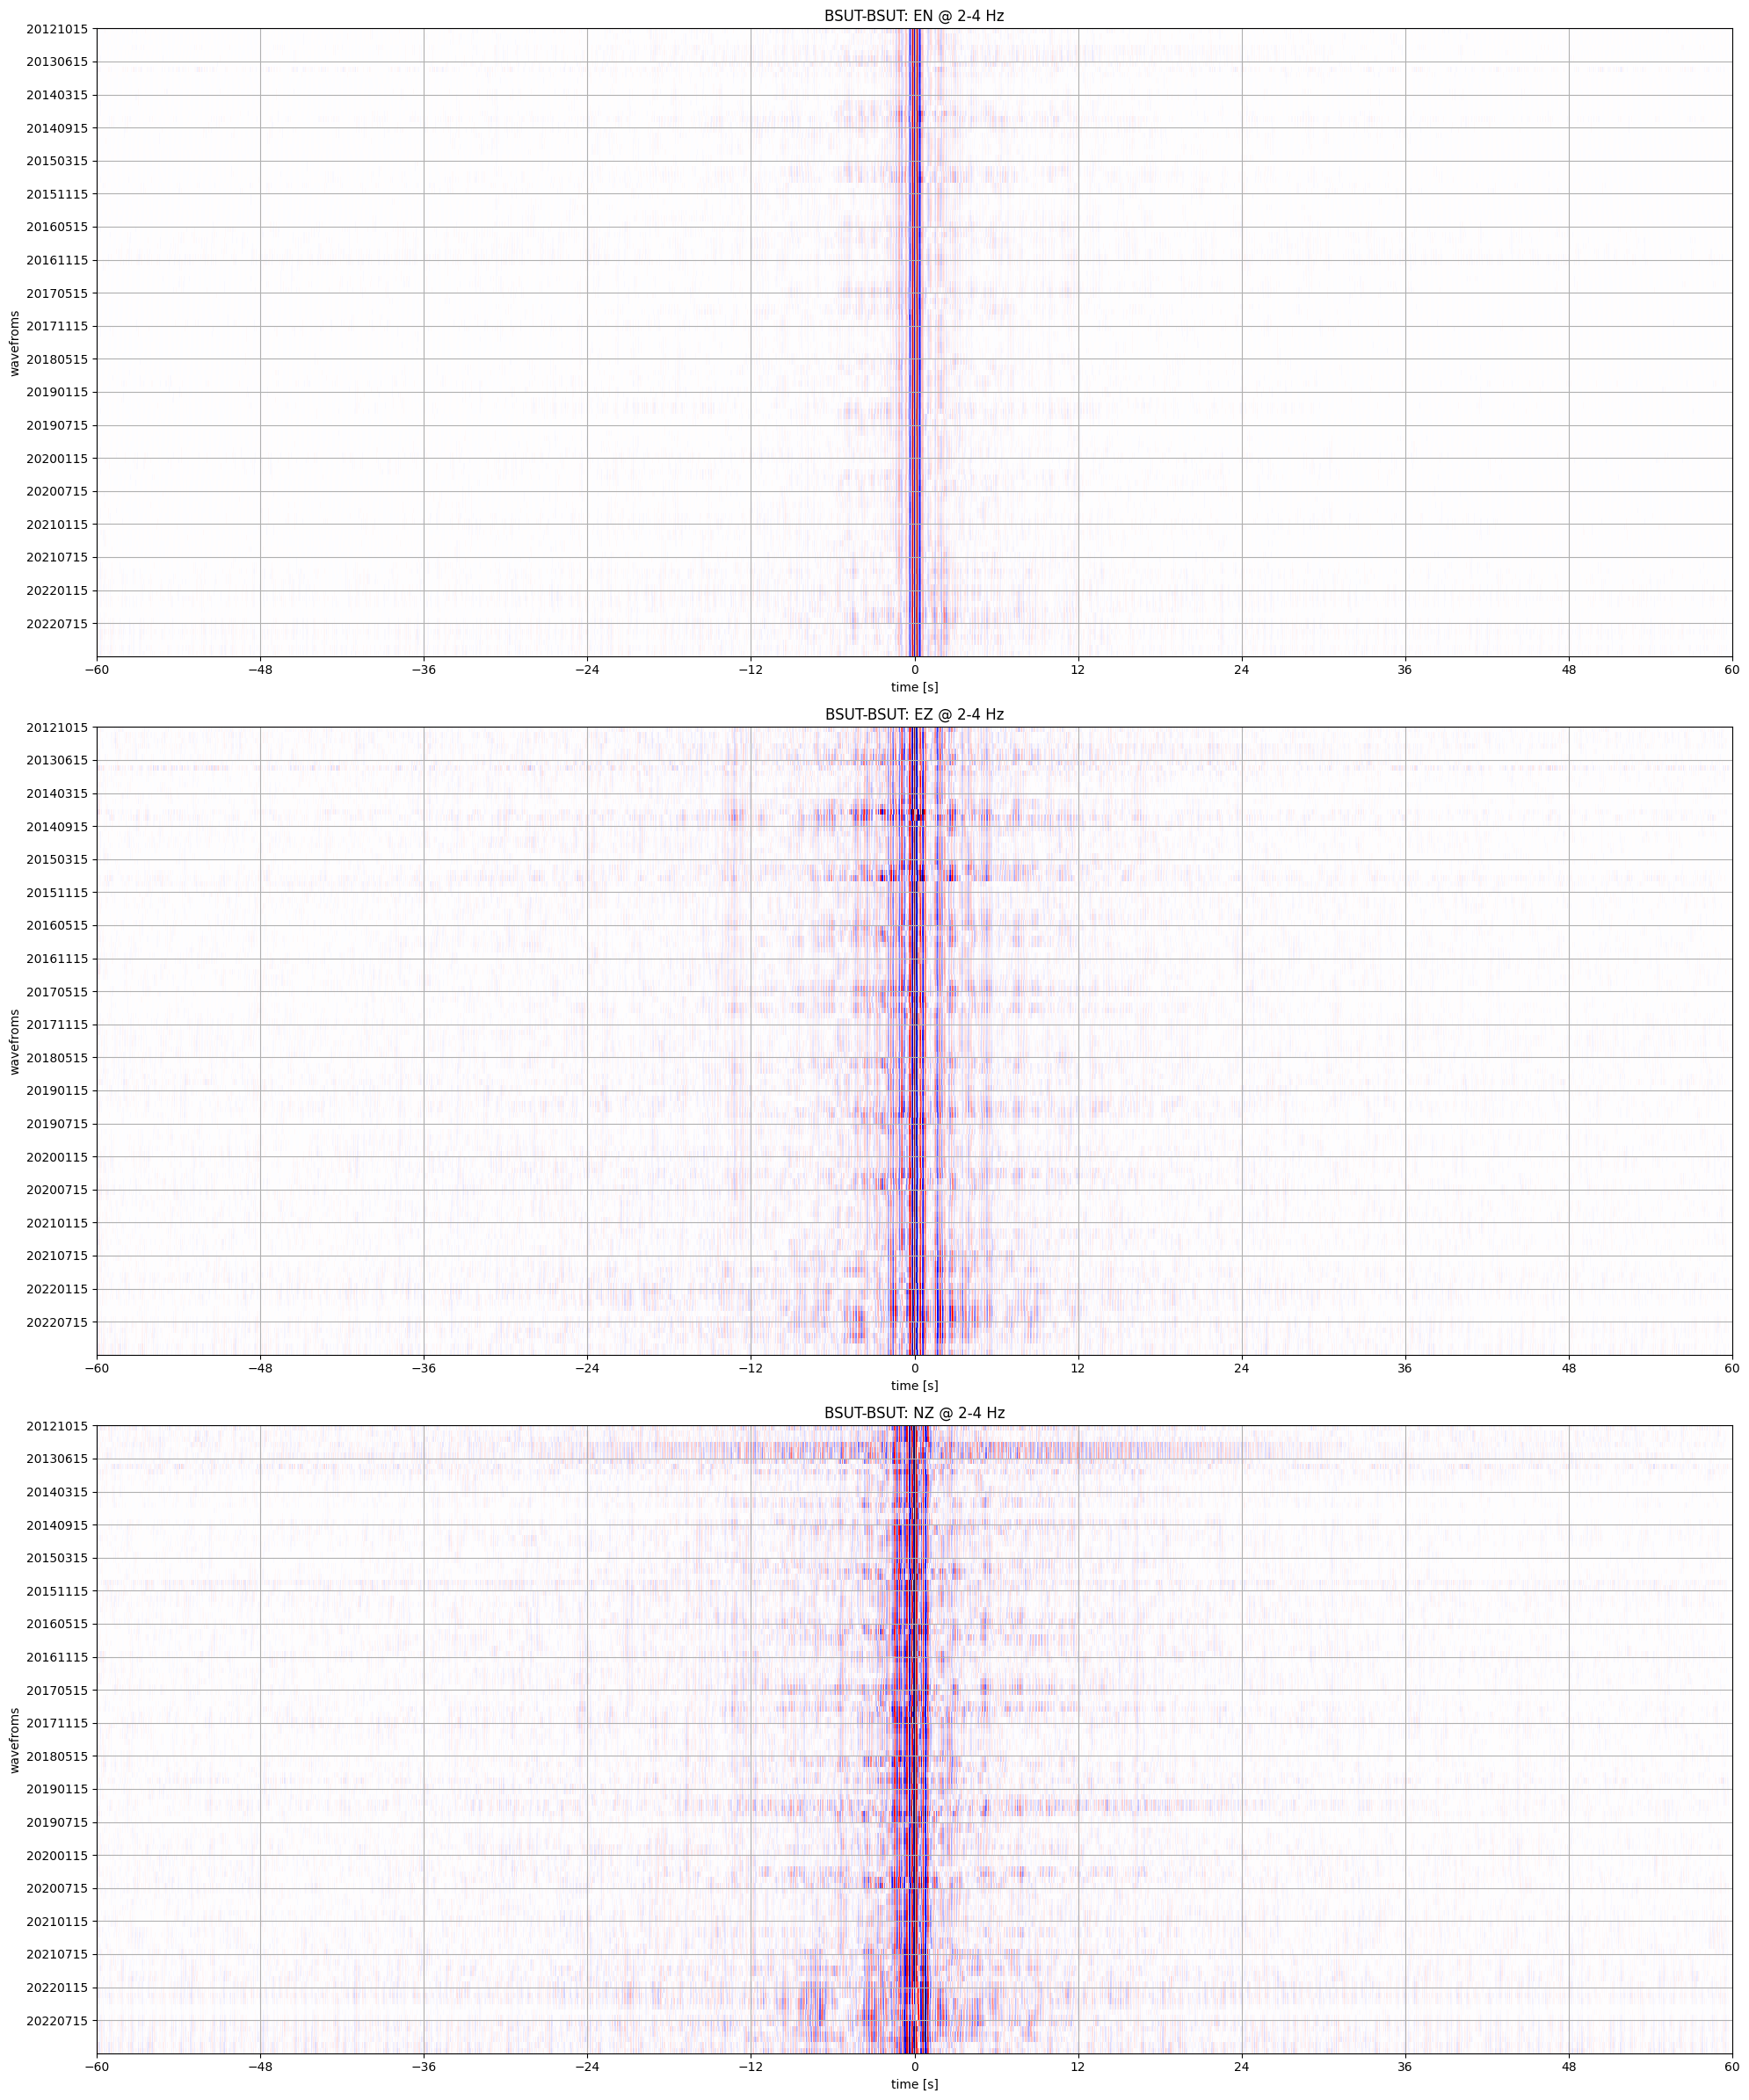

In [317]:
tick_inc=6
t = np.arange(-int(lag), int(lag) + delta, step=int(2 * int(lag) / 10))


fig, ax = plt.subplots(3,1, figsize=(20, 24), sharex=True)
for ncmp, ccomp in enumerate(enz_system):
    cax = ax[ncmp].matshow(bpuu[:, ncmp], cmap="seismic", extent=[-lag, lag, nev , 0], aspect="auto",vmin=-1, vmax=1)
    ax[ncmp].set_title(f"{src}-{rec}: {ccomp} @ {fmin}-{fmax} Hz")
    fig.colorbar = (cax, ax[ncmp].images)
    
    ax[ncmp].set_xlabel("time [s]")
    ax[ncmp].set_ylabel("wavefroms")
    ax[ncmp].set_xticks(t)
    ax[ncmp].set_yticks(np.arange(0, nev, step=tick_inc))
    ax[ncmp].set_yticklabels((actual_ev[0:nev:tick_inc]))
    ax[ncmp].xaxis.set_ticks_position("bottom")
    ax[ncmp].grid(True)
    
plt.tight_layout()
plt.show()

#outfname=f"{netst}_stack_{cctype}_{fmin}-{fmax}Hz.png"
#fig.savefig(outfname, format="png", dpi=200)
#plt.close()

tick_inc=6
t = np.arange(-int(lag), int(lag) + delta, step=1)

fig, ax = plt.subplots(3,1, figsize=(20, 24), sharex=True)
for ncmp, ccomp in enumerate(enz_system):
    cax = ax[ncmp].matshow(bpuu[:, ncmp], cmap="seismic", extent=[-lag, lag, nev , 0], aspect="auto",vmin=-1/2, vmax=1/2)
    ax[ncmp].set_title(f"{src}-{rec}:  {ccomp} @ {fmin}-{fmax} Hz")
    fig.colorbar = (cax, ax[ncmp].images)
    
    ax[ncmp].set_xlabel("time [s]")
    ax[ncmp].set_ylabel("wavefroms")
    ax[ncmp].set_xticks(t)
    ax[ncmp].set_yticks(np.arange(0, nev, step=tick_inc))
    ax[ncmp].set_yticklabels((ev[0:nev:tick_inc]))
    ax[ncmp].xaxis.set_ticks_position("bottom")
    ax[ncmp].grid(True)
    ax[ncmp].set_xlim(-20,20)

plt.tight_layout()
plt.show()

#outfname=f"{netst}_stack_{cctype}_{fmin}-{fmax}Hz.png"
#fig.savefig(outfname, format="png", dpi=200)
#plt.close()

In [318]:
# slide window for cc
#from scipy.signal import hilbert

window_len=1/fmin*6
print("window length (sec)", window_len)
# Parameters
window_size = int(window_len / delta)  # Size of the moving window
print("window size (npts)", window_size)

nstep=window_size//10
window_num = (len(bpref[ncmp]) - window_size)//nstep + 1
print("window number", window_num)


ccmatrix=np.zeros((num_cmp, nev, window_num))
for ncmp, comp in enumerate(enz_system):
    print("Component: ", comp)
    
    tvec=ref_tvec    
    time_series = bpref[ncmp]
    time_series = time_series - np.mean(time_series)
    envelopes = time_series**2
    print("data length", len(time_series))
    
    for tn in range(nev):
        time_series2 = bpuu[tn, ncmp]
        time_series2 = time_series2 - np.mean(time_series2)
        envelopes2 = time_series2**2
        
        # fig, ax= plt.subplots(2, figsize=(20, 4))
        # ax[0].set_title(f"{comp} @ {fmin}-{fmax} Hz")
        # ax[0].plot(tvec, time_series ,label=ref_span[0])
        # ax[0].plot(tvec, time_series2, ls='--',  alpha=0.5, label=scf_span[tn])
        # ax[1].plot(tvec, envelopes)
        # ax[1].plot(tvec, envelopes2, ls='--', alpha=0.5)
        # ax[1].set_yscale("log")
        # ax[1].set_ylim(1e-6,10)
        # ax[1].set_xlim(-lag,lag)
        # ax[0].set_xlim(-lag,lag)
        # ax[0].legend()


        # Compute moving window cross-correlation
        correlations = []
        for i in np.arange(0, len(time_series)-window_size, nstep):
            # Extract segments of the time series
            segment1 = time_series[i :i+window_size]
            segment2 = time_series2[i :i+window_size]
            # Compute cross-correlation
            cross_corr = np.corrcoef(segment1, segment2)[0,1]
            #print(f'window {i} {i} {i+window_size}, {cross_corr:.2f}')
            correlations.append(cross_corr)
        
        ccmatrix[ncmp, tn]=correlations
        
        # plt.figure(figsize=(20, 2))
        # plt.ylim(0,1)
        # plt.plot(correlations, label='value')
        # plt.plot(np.abs(correlations),'--', label='abs value')
        # plt.xlim(0, window_num)
        # plt.xlabel('window (i)')
        # plt.ylabel('Average Cross-correlation')
        # plt.title('Average Cross-correlation Across Segments2')
        # plt.legend()
        # plt.grid(True)
        # plt.show()


window length (sec) 3.0
window size (npts) 60
window number 391
Component:  EN
data length 2401
Component:  EZ
data length 2401
Component:  NZ
data length 2401


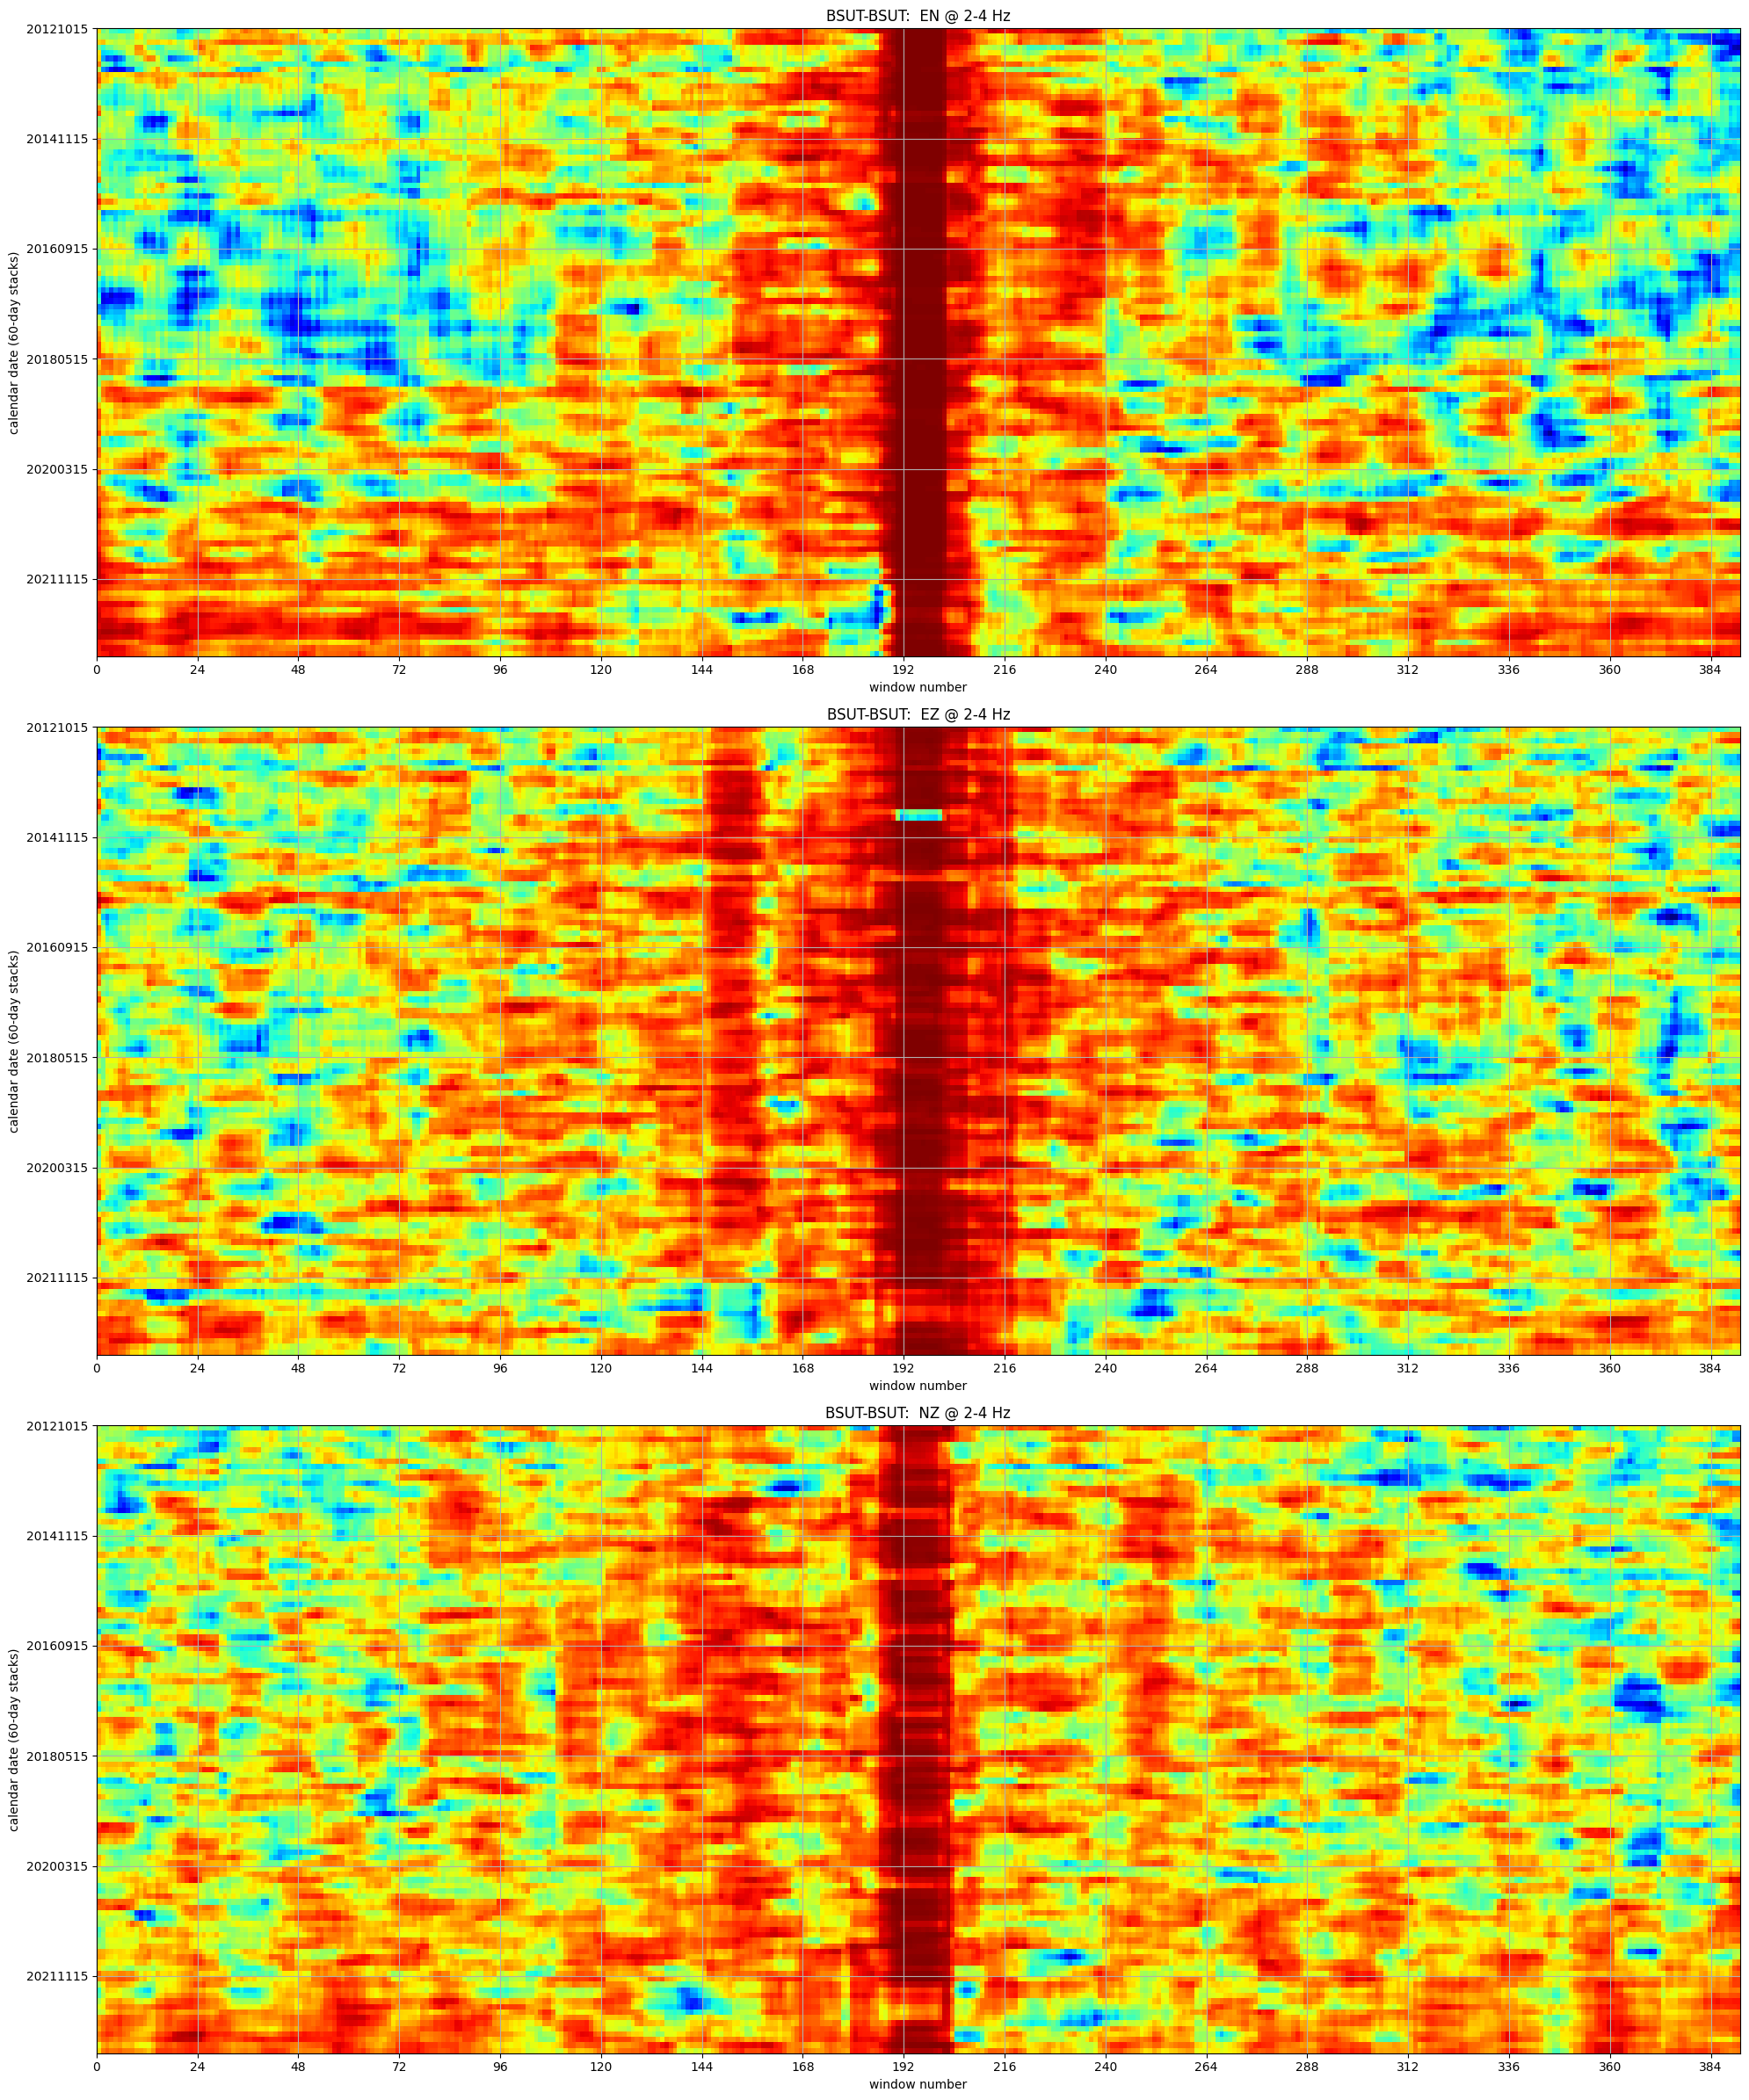

In [319]:
tick_inc=20
t = np.arange(0, window_num, nstep*4)

fig, ax = plt.subplots(3,1, figsize=(20, 24), sharex=True)
for ncmp, ccomp in enumerate(enz_system):
    cax = ax[ncmp].matshow(ccmatrix[ncmp], cmap="jet", extent=[0, window_num, nev , 0], aspect="auto",)
    ax[ncmp].set_title(f"{src}-{rec}:  {ccomp} @ {fmin}-{fmax} Hz")
    fig.colorbar = (cax, ax[ncmp].images)
    
    ax[ncmp].set_xlabel("window number")
    ax[ncmp].set_ylabel("calendar date (60-day stacks)")
    ax[ncmp].set_xticks(t)
    ax[ncmp].set_yticks(np.arange(0, nev, step=tick_inc))
    ax[ncmp].set_yticklabels((actual_ev[0:nev:tick_inc]))
    ax[ncmp].xaxis.set_ticks_position("bottom")
    ax[ncmp].grid(True)


plt.tight_layout()
plt.show()

#outfname=f"{netst}_stack_{cctype}_{fmin}-{fmax}Hz.png"
#fig.savefig(outfname, format="png", dpi=200)
#plt.close()

In [ ]:
print(ccmatrix.shape)
print(bpref.shape)
print(bpuu.shape)
correspond_tlag = ((np.where(ccmatrix[0,0,:])[0] * (nstep)) * delta + window_len/2) - lag
print(f'window size: {window_size} (npt); sliding step: {nstep} (npt);\ncorrespond_tlag: {correspond_tlag}')


print(type(correspond_tlag))

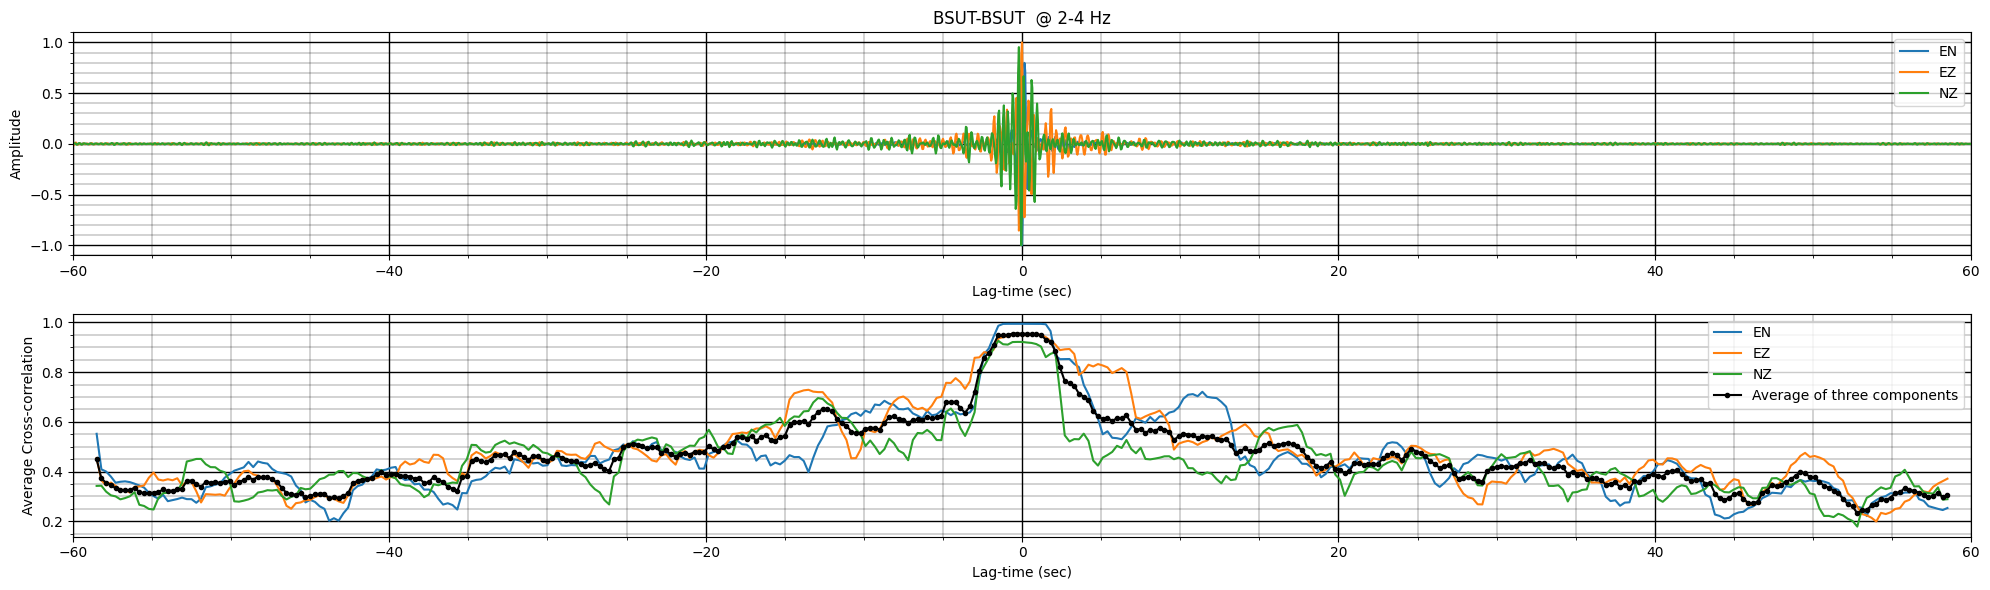

In [321]:
import matplotlib as mpl
fig,ax = plt.subplots(2,figsize=(20, 6))

mean_ccmatrix=np.zeros((num_cmp, window_num))
for ncmp, ccomp in enumerate(enz_system):
    mean_ccmatrix[ncmp]=np.nanmean(ccmatrix[ncmp], axis=0)

    ax[0].plot(ref_tvec, bpref[ncmp], label=ccomp)
    ax[1].plot(correspond_tlag, mean_ccmatrix[ncmp], label=ccomp)
ax[1].plot(correspond_tlag, np.mean(mean_ccmatrix[:], axis=0) , label='Average of three components', color='k',marker='.', )    

ax[0].set_title(f"{src}-{rec}  @ {fmin}-{fmax} Hz")

ax[0].set_ylabel('Amplitude')  
ax[1].set_ylabel('Average Cross-correlation')

for k in range(2):
    ax[k].set_xlim(ref_tvec[0], ref_tvec[-1])
    ax[k].set_xlabel('Lag-time (sec)')
    ax[k].grid(True)
    ax[k].legend(loc='upper right')
    ax[k].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[k].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax[k].grid( which='major', color='k', linewidth=1.0)
    ax[k].grid( which='minor', color='k', linewidth=0.25)
plt.tight_layout()


In [322]:
def fold_arr(cc):
    folded_cc = []
    n = len(cc) // 2  # Assuming cc length is 121, n = 60

    for i in range(n + 1):  # Iterate from 0 to 60
        folded_value = (cc[n + i] + cc[n - i]) / 2  # Average of cc[lag] and cc[-lag]
        folded_cc.append(folded_value)

    return folded_cc


def find_index_below_threshold(arr, threshold=0.8):
    for i, value in enumerate(arr):
        if value < threshold:
            return i
    return None  # If no value below threshold is found


In [323]:
cc_thred = 0.68
fold_cc=fold_arr(np.mean(mean_ccmatrix[:], axis=0))
index = find_index_below_threshold(fold_cc, cc_thred)
print(index, fold_cc[index])
coda_tbeg =  (1/fmin) * 3
coda_tend = correspond_tlag[len(fold_cc)-1+index]

12 0.6747234619957905


391 196


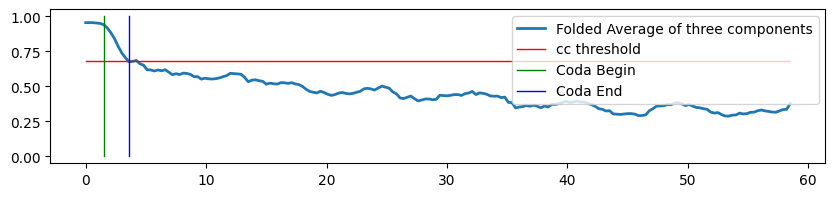

In [324]:
plt.figure(figsize=(10, 2))

print(len((np.mean(mean_ccmatrix[:], axis=0))),len(fold_cc))
plt.plot(correspond_tlag[len(fold_cc)-1:], fold_cc, label='Folded Average of three components', lw=2)
plt.plot([correspond_tlag[len(fold_cc)-1], correspond_tlag[-1]], [cc_thred, cc_thred] , label='cc threshold', color='r', lw=1 )
plt.plot([coda_tbeg, coda_tbeg], [0, 1] , label='Coda Begin', color='g', lw=1 )
plt.plot([coda_tend, coda_tend], [0, 1] , label='Coda End', color='b', lw=1 )
plt.legend(loc='upper right')

We got the coda window and the bandpass scfs and reference by the steps above. Now, we are calculating dv/v and attenuation based on these waveforms and parameters. Eventually, we save results into a pandas dataframe.

In [325]:
from noisepy.monitoring.monitoring_utils import *     # modules for monitoring utils
from noisepy.monitoring.monitoring_methods import stretching
from noisepy.monitoring.attenuation_utils import *    # modules for attenuation monitoring
from noisepy.seis import noise_module


In [326]:
config_monito = ConfigParameters_monitoring() # default config parameters which can be customized

# --- parameters for measuring velocity changes ---
# pre-defined group velocity to window direct and code waves
config_monito.vmin = 2.0  # minimum velocity of the direct waves -> start of the coda window
config_monito.lwin = 10.0  # window length in sec for the coda waves

# basic parameters
config_monito.freq = [fmin, fmax]  # targeted frequency band for waveform monitoring
nfreq = len(config_monito.freq) - 1
config_monito.onelag = False  # make measurement one one lag or two
config_monito.norm_flag = True  # whether to normalize the cross-correlation waveforms
config_monito.do_stretch = True  # use strecthing method or not

# parameters for stretching method
config_monito.epsilon = 0.02  # limit for dv/v (in decimal)
config_monito.nbtrial = 100  # number of increment of dt [-epsilon,epsilon] for the streching

# coda window 
config_monito.coda_tbeg = coda_tbeg  # begin time (sec) of the coda window in lag time
config_monito.coda_tend = coda_tend  # end time (sec) of the coda window in lag time

# --- parameters for measuring attenuation ---
config_monito.smooth_winlen = (1/fmin)*2    # smoothing window length
config_monito.cvel = 2.6                    # Rayleigh wave velocities over the freqency bands
config_monito.atten_tbeg = coda_tbeg
config_monito.atten_tend = coda_tend
config_monito.intb_interval_base = 0.01 

In [327]:
timespans = ev.copy()
sta_pair = src, rec

In [328]:
import yaml
from noisepy.seis.io.datatypes import ConfigParameters,  StackMethod

def load_config(config_file):
    with open(config_file, 'r') as file:
        config = yaml.safe_load(file)
    return config

# load config of the stackstore data products
config =  ConfigParameters()
config_file = 'xcorr_config_debug_xcorr_purewhiten.yml'
config = load_config(config_file)
print(config)


{'acorr_only': True, 'cc_len': 600, 'cc_method': 'xcorr', 'channels': ['HHE', 'HHN', 'HHZ', 'BHE', 'BHN', 'BHZ'], 'client_url_key': 'IRIS', 'correction': False, 'correction_csv': None, 'down_list': False, 'end_date': '2022-12-31T00:00:00Z', 'freq_norm': 'rma', 'freqmax': 10.0, 'freqmin': 0.08, 'inc_hours': 24, 'keep_substack': False, 'lamax': 42.0, 'lamin': 32.0, 'lomax': -114.0, 'lomin': -124.0, 'max_over_std': 10, 'maxlag': 60, 'ncomp': 3, 'net_list': ['CI'], 'respdir': None, 'rm_resp': False, 'rm_resp_out': 'VEL', 'rotation': True, 'samp_freq': 20.0, 'single_freq': False, 'smooth_N': 12000, 'smoothspect_N': 1, 'stack_method': 'linear', 'start_date': '2016-01-01T00:00:00Z', 'stations': ['DLA', 'LAF', 'LJR'], 'stations_file': None, 'stationxml': False, 'step': 600.0, 'storage_options': {}, 'substack': False, 'substack_len': 600, 'time_norm': 'one_bit', 'xcorr_only': False}


In [329]:
# calculate the number of segments
num_chunk = len(timespans)

npts_one_segmt = int(2 * maxlag * samp_freq) + 1
num_segmts = 1
print(f"there are ",num_segmts," segments/windows and ",npts_one_segmt," points in each segments and overall",num_chunk," number of time chunks")

there are  1  segments/windows and  2401  points in each segments and overall 204  number of time chunks


In [330]:
nccomp = num_cmp
cc_time  = np.zeros( (num_chunk * num_segmts), dtype=np.float32)
print(cc_time.shape)

(204,)


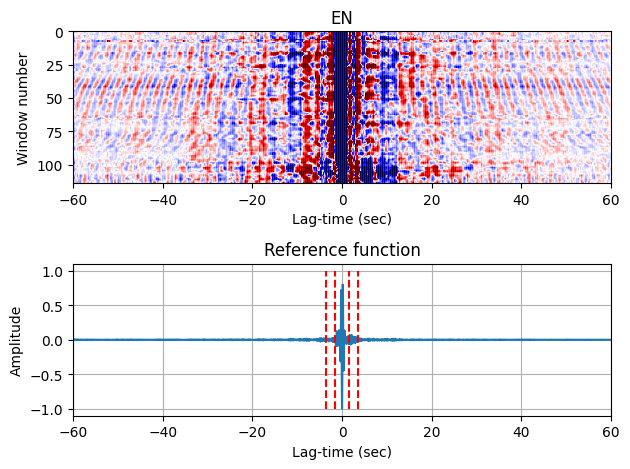

In [331]:
# in single-station cross-component case : enz_system = [ "EN", "EZ", "NZ"]
freq1=config_monito.freq[0]
freq2=config_monito.freq[1]
dt=1/samp_freq

## Choose a targeted component
comp = "EN"

## using the stackstore ref to replace the stacking here for long-term monitoring
tref=bpref[0]
tcur=bpuu[:,0,:]


# Plot
fig,ax=plt.subplots(2,1)
ax[0].imshow(tcur,extent=[-maxlag, maxlag, nev, 0], aspect='auto',vmin=-0.01,vmax=0.01, cmap='seismic')
ax[0].set_title(comp)
ax[0].set_xlabel('Lag-time (sec)')
ax[0].set_ylabel('Window number')

ax[1].set_xlim(-maxlag, maxlag);ax[1].grid(True)
ax[1].plot(ref_tvec, tref)
ax[1].set_title('Reference function')
ax[1].set_xlabel('Lag-time (sec)')
ax[1].set_ylabel('Amplitude')

ax[1].plot([coda_tbeg, coda_tbeg], [-1, 1], 'r--', label='Coda Begin')
ax[1].plot([-coda_tbeg, -coda_tbeg], [-1, 1], 'r--', label='Coda Begin')
ax[1].plot([coda_tend, coda_tend], [-1, 1], 'r--', label='Coda End')
ax[1].plot([-coda_tend, -coda_tend], [-1, 1], 'r--', label='Coda End')

plt.tight_layout()
plt.show()

In [332]:
# define the window index for positive and negative lag time
pwin_indx, nwin_indx = window_indx_def(npts_one_segmt, config_monito.coda_tbeg, config_monito.coda_tend, dt)

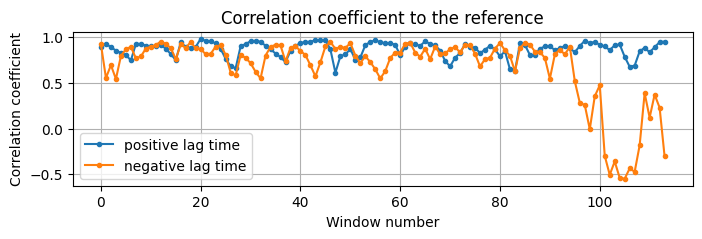

In [333]:
nwin=nev

# Calculate the correlation coefficient between the coda and the reference coda
pcor_cc = np.zeros(shape=(nwin), dtype=np.float32)
ncor_cc = np.zeros(shape=(nwin), dtype=np.float32)
for i in range(nwin):
  pcor_cc[i] = np.corrcoef(tref[pwin_indx], tcur[i, pwin_indx])[0, 1]
  ncor_cc[i] = np.corrcoef(tref[nwin_indx], tcur[i, nwin_indx])[0, 1]

# Plot
plt.figure(figsize=(8,2));plt.grid(True)
plt.plot(pcor_cc, '.-', label='positive lag time')
plt.plot(ncor_cc, '.-', label='negative lag time')
plt.title('Correlation coefficient to the reference')
plt.ylabel('Correlation coefficient')
plt.xlabel('Window number')
plt.legend()

In [334]:
# initializing arrays
dvv_stretch = np.zeros(shape=(nwin, 4), dtype=np.float32)

# define the parameters for stretching
para=dict()
para["t"] = np.arange(-maxlag, maxlag+dt,dt)
para["freq"] = [freq1, freq2]
para["twin"] = [config_monito.coda_tbeg, config_monito.coda_tend]
para["dt"] = dt

In [335]:
print( src, rec, nwin)
nccomp=len(enz_system)

# initializing arrays
all_dvv= np.zeros(shape=(nccomp, nwin), dtype=np.float32)
all_err= np.zeros(shape=(nccomp, nwin), dtype=np.float32)
results_dvv= np.zeros(shape=(nwin), dtype=np.float32)
results_err= np.zeros(shape=(nwin), dtype=np.float32)
   
for icomp in range(0,nccomp):
    comp = enz_system[icomp]   
    
    for ii in range(nwin):
        # casual and acasual lags for both ref and cur waveforms
        pcur = bpuu[ii, icomp , pwin_indx]
        ncur = bpuu[ii, icomp, nwin_indx]
        pref = bpref[icomp, pwin_indx]
        nref = bpref[icomp, nwin_indx]
        
        # functions working in time domain
        if config_monito.do_stretch:
            (
                dvv_stretch[ii, 0],
                dvv_stretch[ii, 1],
                cc,
                cdp,
            ) = stretching(pref, pcur, config_monito.epsilon, config_monito.nbtrial, para)
            (
                dvv_stretch[ii, 2],
                dvv_stretch[ii, 3],
                cc,
                cdp,
            ) = stretching(nref, ncur, config_monito.epsilon, config_monito.nbtrial, para)
    all_dvv[icomp]=(dvv_stretch[:, 0]+dvv_stretch[:, 2])/2.0
    all_err[icomp]=np.sqrt(dvv_stretch[:, 1]**2+dvv_stretch[:, 3]**2)
    print('component: ',comp,' completed. ')
    results_dvv+=all_dvv[icomp]
    results_err+=all_err[icomp]**2
results_dvv=results_dvv/nccomp
results_err=np.sqrt(results_err)
print(all_dvv.shape, results_dvv.shape, )
nwin=len(results_dvv)
            

BSUT BSUT 114
component:  EN  completed. 
component:  EZ  completed. 
component:  NZ  completed. 
(3, 114) (114,)


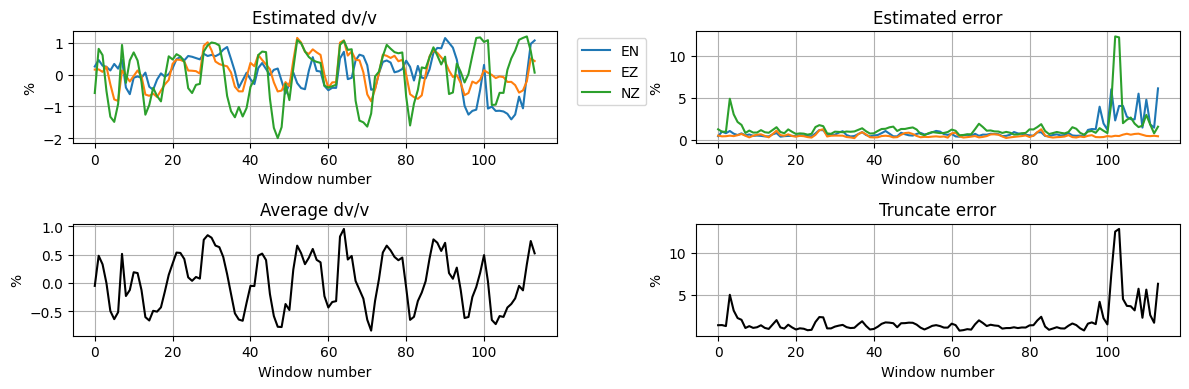

In [336]:
fig,ax=plt.subplots(2,2,figsize=(12,4))
ax[0,0].plot(all_dvv.T)
ax[0,0].legend(enz_system, loc='upper right', bbox_to_anchor=(1.2,1))
ax[0,0].grid(True)
ax[0,0].set_title('Estimated dv/v')
ax[0,0].set_xlabel('Window number')
ax[0,0].set_ylabel('%')

ax[0,1].plot(all_err.T);ax[0,1].grid(True);#ax[0,1].set_ylim(0,100)
ax[0,1].set_title('Estimated error')
ax[0,1].set_xlabel('Window number')
ax[0,1].set_ylabel('%')

ax[1,0].plot(results_dvv.T, 'k');ax[1,0].grid(True)
ax[1,0].set_title('Average dv/v')
ax[1,0].set_xlabel('Window number')
ax[1,0].set_ylabel('%')

ax[1,1].plot(results_err.T, 'k');ax[1,1].grid(True)
ax[1,1].set_title('Truncate error')
ax[1,1].set_xlabel('Window number')
ax[1,1].set_ylabel('%')

plt.tight_layout()

### Step 5: Measure attenuation parameter -- intrinsic absorption parameter b
Preparing mean-squared values in time seires for measuring intrinsic parameter. We follow these steps:
* Prepare smoothed mean-squared data (msv) in a given frequency band,
* Get the average msv (msv_mean) from all components, and also the symmetric msv (fmsv_mean)
* Measure intrinsic absorption parameter b (results_intb) and transfer it to intrinsic Q (Qi)

temp1: (114, 2401), msv (3, 114, 2401), msv_temp (114, 2401)


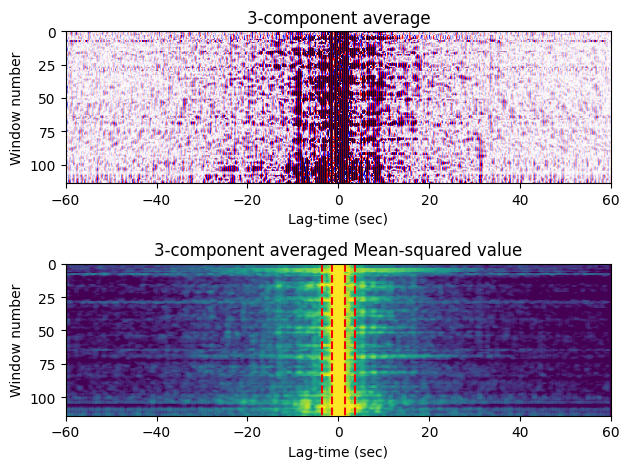

In [337]:
from matplotlib.colors import LogNorm
#enz_system = ["EN", "EZ", "NZ"]
nccomp=len(enz_system)
winlen=config_monito.smooth_winlen

# Restore calendar time from cc_time array 
win_time=[]

# initializing arrays 
tcur_temp1 = np.zeros(shape=(nev, npts_one_segmt))
msv=np.zeros((nccomp, nev, npts_one_segmt))
msv_temp=np.zeros((nev, npts_one_segmt))
print(f'temp1: {tcur_temp1.shape}, msv {msv.shape}, msv_temp {msv_temp.shape}')

# get all components average
for icomp in range(0,nccomp):
    comp = enz_system[icomp]
    
    # bandpass filter the data.
    tcur_temp2 = np.zeros(shape=(nev, npts_one_segmt))
    for iev in range(nev):
        tcur_temp2[iev]=bpuu[iev, icomp]
        win_time.append((timespans[i])) #.strftime("%Y-%m-%dT%H:%M"))
        #print((timespans[i])) #.strftime("%Y-%m-%dT%H:%M"))
        
        para = { 'winlen':winlen, 'dt':dt , 'npts': len(tcur_temp2[iev])}
        msv[icomp,iev] = get_smooth(tcur_temp2[iev], para)
        #print(tcur_temp2.shape, msv[icomp].shape)

        tcur_temp1[iev] = tcur_temp1[iev] + tcur_temp2[iev]
        
    msv_temp = msv_temp + msv[icomp]

tcur_avef = np.zeros(shape=(nwin, npts_one_segmt))
msv_mean = np.zeros(shape=(nwin, npts_one_segmt))
#print(nwin, tcur_avef.shape, msv.shape, msv_mean.shape)

tcur_avef = tcur_temp1[:nwin,:]/nccomp
msv_mean = msv_temp[:nwin,:]/nccomp
msv_mean = msv_mean/np.max(msv_mean)
del  tcur_temp1, tcur_temp2, msv_temp 

fig,ax=plt.subplots(2,1)
ax[0].imshow(tcur_avef, extent=[-maxlag, maxlag, nev,0],aspect='auto',vmin=-0.01,vmax=0.01, cmap='seismic')
ax[0].set_title(str(nccomp)+"-component average")
ax[0].set_ylabel('Window number')
ax[0].set_xlabel('Lag-time (sec)')
ax[1].imshow(msv_mean, extent=[-maxlag, maxlag, nev,0],aspect='auto', norm=LogNorm(vmin=0.0001, vmax=0.1))
ax[1].set_title(str(nccomp)+'-component averaged Mean-squared value')
ax[1].set_xlabel('Lag-time (sec)')
ax[1].set_ylabel('Window number')
plt.tight_layout()
ax[1].plot([coda_tbeg, coda_tbeg], [0, nev], 'r--', label='Coda Begin')
ax[1].plot([-coda_tbeg, -coda_tbeg], [0, nev], 'r--', label='Coda Begin')
ax[1].plot([coda_tend, coda_tend], [0, nev], 'r--', label='Coda end')
ax[1].plot([-coda_tend, -coda_tend], [0, nev], 'r--', label='Coda end')

    

In [338]:
half_npts=(npts_one_segmt-1)//2
fmsv_mean=np.zeros((nwin,2,half_npts+1))

for ntw in range(nwin):
    sym=get_symmetric(msv_mean[ntw],half_npts)
    fmsv_mean[ntw][0]=np.arange(0, maxlag+dt,dt)
    fmsv_mean[ntw][1]=sym


In [339]:
twinbe=np.ndarray((1,1,2))
twinbe[0,0,0]=config_monito.atten_tbeg
twinbe[0,0,1]=config_monito.atten_tend

cvel=config_monito.cvel # Rayleigh wave velocities over the freqency bands
vdist=np.zeros((1))     # station distance
mfpx=np.zeros(1)        # mean_free_path search array
intby=np.zeros(80)      # intrinsic_b search array
config_monito.intb_interval_base=0.01 # interval base for a grid-searching process

In [340]:
print(coda_tbeg, coda_tend)

1.5 3.6000000000000014


In [341]:
# getting the sum of squared residuals (SSR) between Eobs and Esyn  
SSR_final=np.zeros((len(mfpx),len(intby)))
SSR=np.zeros((nwin,1,len(mfpx),len(intby)))

for ntw in range(nwin):
    data=np.zeros(shape=(1,2,half_npts+1))
    data[0,:,:]=fmsv_mean[ntw]
    #print(data.shape,fmsv_mean[ntw].shape)
    # parameters for getting the sum of squared residuals (SSR) between Eobs and Esyn 
    para={ 'fb':0 , 'vdist':vdist, 'npts':npts_one_segmt, 'dt':dt, 'cvel':cvel, \
        'mfp':mfpx, 'intb':intby,'twin':twinbe, 'fmsv':data }
    # call function get_SSR
    SSR_final, mfpx, intby = get_SSR(1, para )

    SSR[ntw][0]=SSR_final
print(SSR.shape)

(114, 1, 1, 80)


In [342]:
def plot_fitting_result(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist,twind,fmin,fmax,win_num):
    plt.figure(figsize=(6,2))
    plt.yscale('log', base=10)

    pymax=np.max(Eobs[:-2]*5)
    pymin=10**(-6)
    print( pymin , pymax )
    plt.ylim( pymin , pymax )
    plt.plot( tt, Eobs, "k-", linewidth=1)
    plt.plot( tt, Esyn, "b--", linewidth=1)
    plt.plot([twind[0],twind[0],twind[-1],twind[-1],twind[0]],[pymin, pymax,pymax,pymin,pymin],"r", linewidth=2)

    plt.title("%s @%4.2f-%4.2f Hz, intrinsic b: %.2f, Window no. %d" \
            % ( fname,fmin,fmax,intrinsic_b, win_num))
    plt.xlabel("Lag time (sec)")
    plt.ylabel("Energy density Amp")
    plt.tight_layout()   
    plt.show()
                    

In [ ]:
# getting the optimal value from the SSR
result_intb=np.zeros((nwin,1))
result_mfp=np.zeros((nwin, 1))

Eobs=np.ndarray((1,half_npts))
Esyn=np.ndarray((1,half_npts))
aa=0
r=np.take(vdist[aa],0) 

fmin=freq1
fmax=freq2
wfcen=2.0*np.pi*((freq1+freq2)/2.0)

for ntw in range(nwin):

    data=np.zeros(shape=(1,2,half_npts+1))
    data[0,:,:]=fmsv_mean[ntw]
    # parameters for getting optimal value from the sum of squared residuals (SSR) between Eobs and Esyn 
    para={ 'fb':0, 'fmin':fmin, 'fmax':fmax, 'vdist':vdist, 'npts':npts_one_segmt, 'dt':dt, 'cvel':cvel, 'filenum':aa, \
        'mfp':mfpx, 'intb':intby, 'twin':twinbe, 'fmsv':data, 'SSR':SSR[ntw] , 'sta':sta_pair}
    # call function get_optimal
    result_intb[ntw], result_mfp[ntw], Eobs, Esyn = get_optimal_Esyn(1,para)
    # plotting fitting results
    #if ntw == 32:
    plot_fitting_result(result_mfp,result_intb[ntw],data[0,0,:], 
                    Eobs,Esyn,sta_pair,vdist[0],twinbe[0][0],fmin,fmax,ntw)
    
intQ=np.zeros((nwin,1)) 
intQ=wfcen/result_intb


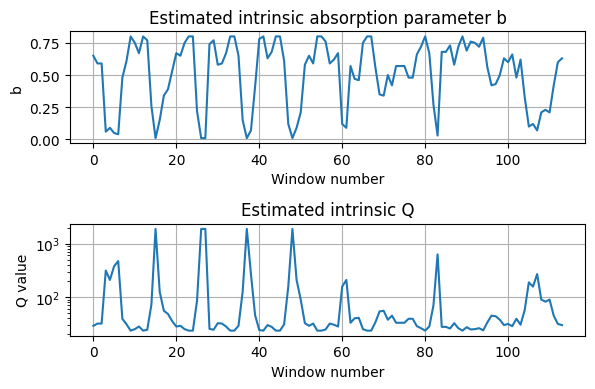

In [344]:
fig,ax=plt.subplots(2,1,figsize=(6,4))
ax[0].plot(result_intb, label='intrinsic b')
ax[0].grid(True)
ax[0].set_title('Estimated intrinsic absorption parameter b')
ax[0].set_xlabel('Window number')
ax[0].set_ylabel('b')

ax[1].plot(intQ, label='Q')
ax[1].set_yscale("log")
ax[1].grid(True)
ax[1].set_title('Estimated intrinsic Q')
ax[1].set_xlabel('Window number')
ax[1].set_ylabel('Q value')
plt.tight_layout()

### Step : Output results as a csv file

In [345]:
# Restore calendar time from cc_time array 
#cal_time=win_time[:nwin]
cal_time=win_time[:len(win_time)//3]
print(len(cal_time),results_dvv.shape,result_intb[:,0].shape, intQ.shape )


114 (114,) (114,) (114, 1)


In [346]:
from datetime import datetime

midpoint = np.zeros(nev, dtype=datetime)
for iev in range(nev):
    #print(timespans[iev], type(timespans[iev]))
    midpoint[iev] = datetime.strptime(actual_ev[iev],"%Y%m%d")
    

In [347]:
import pandas as pd

fieldnames = ['time', 'dvv','err','int_b','wfcen', 'Q']
fcsv="Monitoring_output.csv"
data={
'time': midpoint,
'dvv':  results_dvv,
'err':  results_err,
'int_b': result_intb[:,0],
'wfcen': np.full((nwin),wfcen),
'Q': intQ[:,0],
}

df=pd.DataFrame(data)
df.to_csv(fcsv,columns=fieldnames,sep=',',index = None, header=True, float_format="%.4f" )

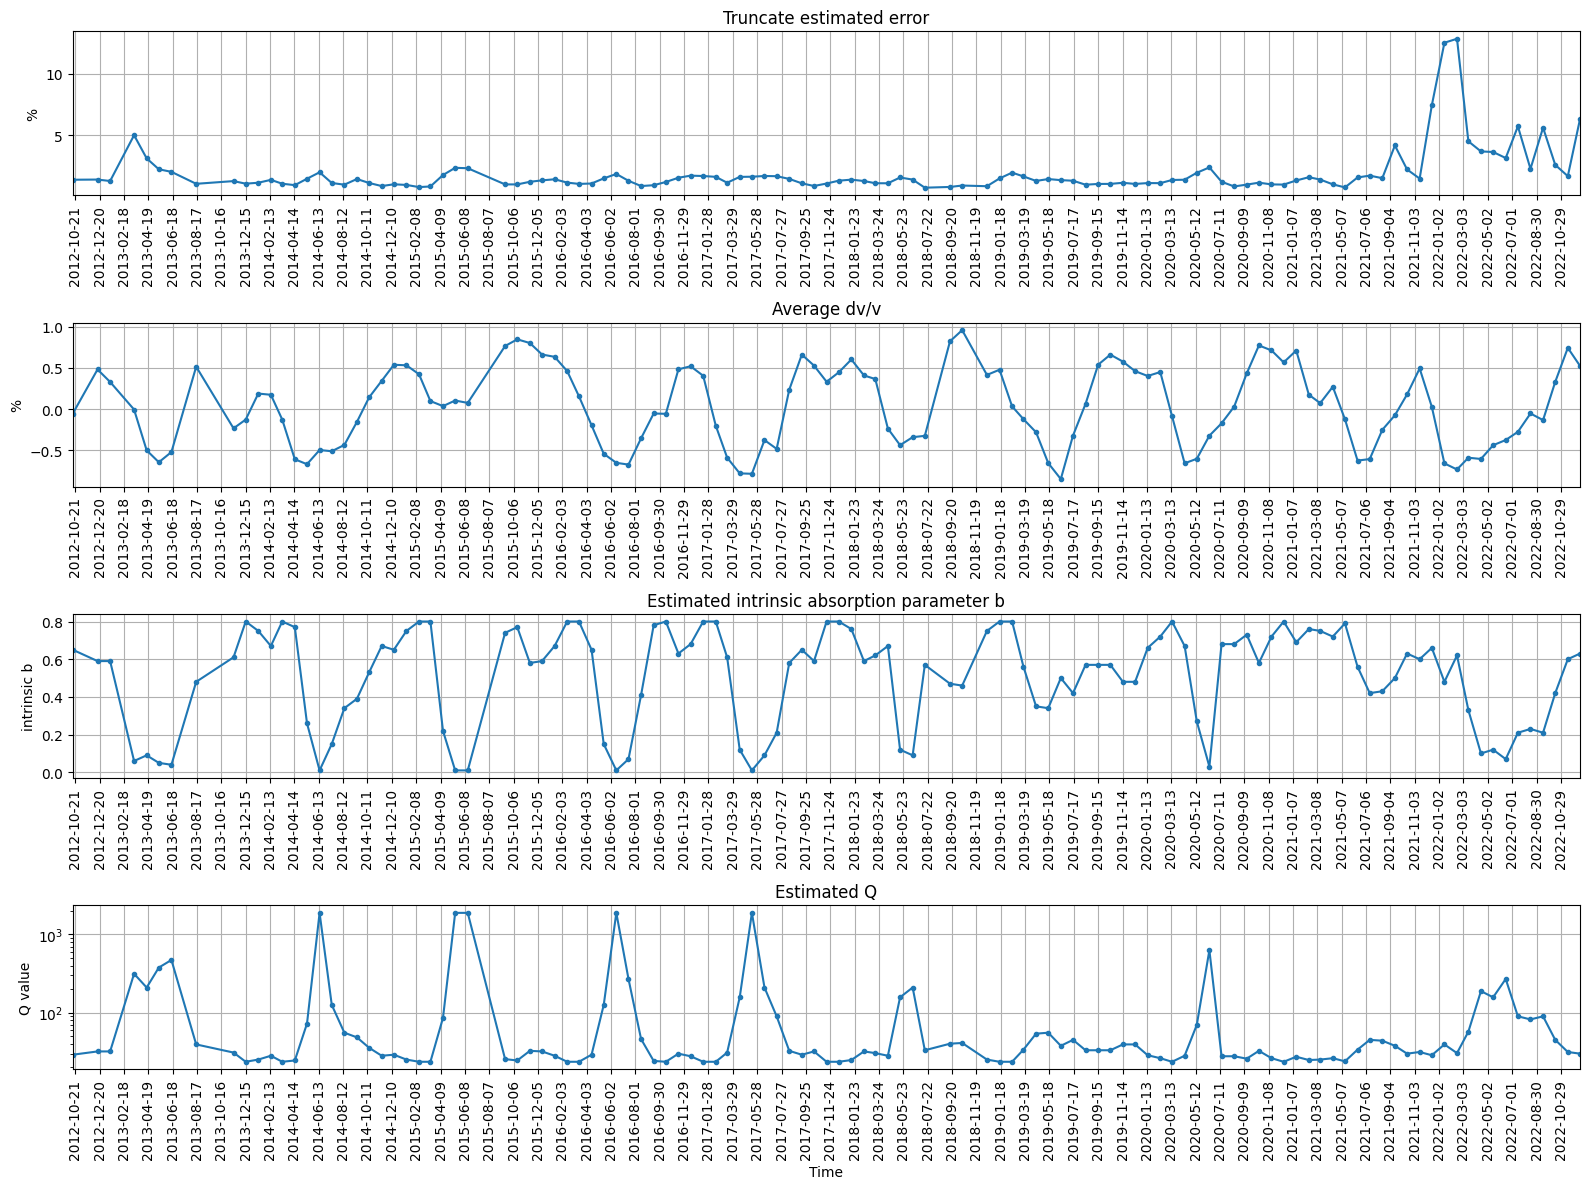

In [348]:
import matplotlib.dates as mdates

fig,ax=plt.subplots(4,1,figsize=(16,12))

#t=[ timespans[d] for d in cal_time]
t=midpoint


ax[0].plot_date(t, results_err, '.-', label='error of dv/v (%)')
ax[0].set_title('Truncate estimated error')
ax[0].set_ylabel('%')

ax[1].plot_date(t, results_dvv, '.-', label='dv/v (%)')
ax[1].set_title('Average dv/v')
ax[1].set_ylabel('%')

ax[2].plot_date(t, result_intb[:,0], '.-', label='intrinsic b')
ax[2].set_title('Estimated intrinsic absorption parameter b')
ax[2].set_ylabel('intrinsic b')

ax[3].plot_date(t,intQ[:,0],'.-',  label='Q')
ax[3].set_title('Estimated Q')
ax[3].set_ylabel('Q value')
ax[3].set_xlabel('Time')
ax[3].set_yscale('log')
for k in range(4):
    ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[k].set_xlim(np.datetime64(t[0]), np.datetime64(t[-1]))
    ax[k].xaxis.set_major_locator(mdates.DayLocator(interval=60))
    ax[k].tick_params('x',labelrotation=90)
    ax[k].grid(True)

plt.tight_layout()

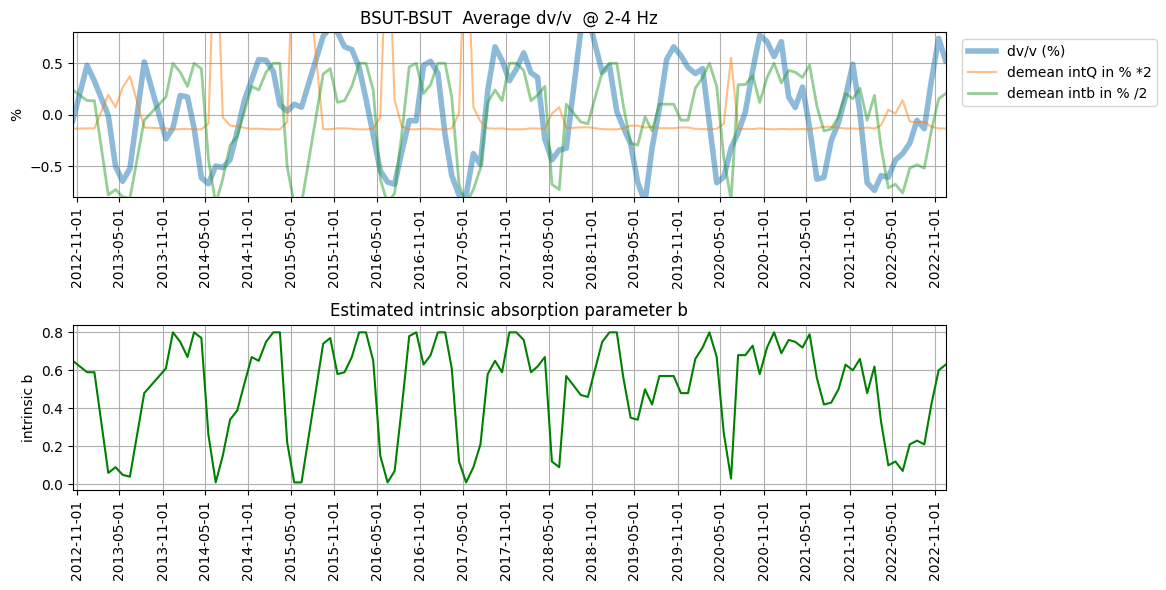

In [350]:
import matplotlib.dates as mdates

fig,ax=plt.subplots(2,1,figsize=(12,6))

demeanQ=np.zeros((nwin,1))
demeanQ=(intQ[:,0]-np.mean(intQ[:,0]))
demeanQ=demeanQ/np.max(demeanQ)
 
demeanB=np.zeros((nwin,1))
demeanB=(result_intb[:,0]-np.mean(result_intb[:,0]))
demeanB=demeanB/np.max(demeanB)


ax[0].plot_date(t, results_dvv, '-', lw=4, alpha=0.5, label=f'dv/v (%)')
ax[0].set_title(f'{src}-{rec}  Average dv/v  @ {fmin}-{fmax} Hz')
ax[0].set_ylabel('%')
ax[0].set_ylim(-0.8,0.8)
ax[0].plot_date(t, demeanQ*2, '-', alpha=0.5,  label='demean intQ in % *2')
ax[0].plot_date(t, demeanB/2, '-', alpha=0.5, lw=2,  label='demean intb in % /2')
ax[0].legend(loc='upper right', bbox_to_anchor=(1.25,1))

ax[1].plot_date(t, result_intb[:,0], '-', color='green', label='intrinsic b')
ax[1].set_title('Estimated intrinsic absorption parameter b')
ax[1].set_ylabel('intrinsic b')

specific_months = pd.date_range(start=actual_ev[0], end='2022-12-31', freq='6MS')

for k in range(2):
    ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[k].set_xlim(np.datetime64(t[0]), np.datetime64(t[-1]))
    ax[k].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[k].set_xticks(specific_months)
    ax[k].tick_params('x',labelrotation=90)
    ax[k].grid(True)

plt.tight_layout()